In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns     # you can install this with "pip install seaborn"
import sys
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Settings
Edit the variables below to indicate which plots to generate, the algs list is a list of subdirectories with results (they must contain the file parsed-power-aggregate.txt.

In [2]:
algs = ['MST/output-16epv','MST/output-8epv','MST/output-real','CC/output-16epv','CC/output-8epv','CC/output-real']
algs = ['MST/output-real-new']
whats = ['Total CPU Energy (J)','Average CPU Power (W)']
epvs = ['8','16']
nws = ['ER','G']
nws = ['com-lj-org-weighted','soc-pokec','youtubeNetwork']
insperc = ['100','75']
sleep_power={1:35.59980, 2:32.50874, 4:39.00752, 8:27.53429, 16:29.59654, 24:26.78392, 
             32:28.23629, 40:29.28156, 48:29.53099, 56:27.61415, 64:25.24939, 72:29.56577}
sleep_energy={1:356.00497, 2:325.09772, 4:390.13837, 8:275.48913, 16:296.30119, 24:268.22497, 
             32:283.00666, 40:293.51369, 48:296.04856, 56:276.91622, 64:253.14684, 72:296.29419}
galois = {}; insertion = {}; deletion={}

## Functions
A couple of functions that extract the data and generate the plots.

In [44]:
def genBoxPlot(alg, what, insertion, deletion, galois=None):
    print(alg,what)
    baseline=[]

    if what=='Average CPU Power (W)': baseline = sleep_power
    # Set up dataframe columns
    if galois:
        columns = ['Key','Threads', alg+'-ins',alg+'-del','Galois']
    else:
        #if baseline: columns = ['Key','Threads','Baseline', alg+'-ins',alg+'-del']
        columns = ['Key','Threads', alg+'-ins',alg+'-del']
    df = pd.DataFrame(columns = columns)

    # Populate dataframe
    for k,v in insertion.items():
        (w,key) = k
        if w != what: continue

        threads = int(key.split('_')[-1])
        m = len(insertion[k])
        if k in deletion.keys() and len(deletion[k]): m = len(deletion[k])
        if galois:
            for ind in range( min( len(insertion[k]), len(galois[k]) ) ):
                if baseline:
                    #df2 = pd.DataFrame([ [ k, threads, baseline[threads],insertion[k][ind]-baseline[threads], deletion[k][ind]-baseline[threads], galois[k][ind]-baseline[threads]] ], columns=columns)
                    df2 = pd.DataFrame([ [ k, threads, insertion[k][ind]-baseline[threads], deletion[k][ind]-baseline[threads], galois[k][ind]-baseline[threads]] ], columns=columns)
                else:
                    df2 = pd.DataFrame([ [ k, threads, insertion[k][ind], deletion[k][ind], galois[k][ind]] ], columns=columns)
        else:
            for ind in range( min( len(insertion[k]), m ) ):
                if baseline: df2 = pd.DataFrame([ [k, threads, insertion[k][ind]-baseline[threads], deletion[k][ind]]-baseline[threads] ], columns=columns)
                else: df2 = pd.DataFrame([ [k, threads, insertion[k][ind], deletion[k][ind]] ], columns=columns)
        df = df.append(df2, ignore_index=True)

    if df.empty: 
        print(what, ': No data')
        return
    print(df.head(10000).to_string())

    if galois:
        #if baseline: dd=pd.melt(df,id_vars=['Threads'],value_vars=['Baseline', alg+'-ins',alg + '-del','Galois'],var_name='Operation')
        dd=pd.melt(df,id_vars=['Threads'],value_vars=[alg+'-ins',alg + '-del','Galois'],var_name='Operation')
    else:
        dd=pd.melt(df,id_vars=['Threads'],value_vars=[alg+'-ins',alg + '-del'],var_name='Operation')

    #ax = sns.boxplot(x='Threads',y='value',data=dd,hue='Operation',palette="Set2") # also swarmplot
    if baseline:
        #ax = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation',palette="Set2",markers=['.',"^", "o","*"],linestyles=['none',"-", "--", ":"])
        ax = sns.boxplot(x='Threads',y='value',data=dd,hue='Operation',palette="Set3")
    else:
        #ax = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation',palette="Set3",markers=["^", "o","*"],linestyles=["-", "--", ":"])
        ax = sns.boxplot(x='Threads',y='value',data=dd,hue='Operation',palette="Set3")
    ax.patch.set_alpha(0.5)
    plt.ylabel(what)

    filename = what + '.pdf'
    title = what
    plt.title(title)
    plt.savefig(filename)
    plt.show()

In [61]:
def extractAndPlotData(lines,alg,algnames,what,epvs,nwnames,insperc,realnetwork=False):
    global insertion, deletion, galois
    insertion = deletion = galois = {}
    nw = ins = ''
    
    for line in lines:
        #algorithm,execution_phase,scale,edges_per_vertex,RMAT_type,insertion_percent,changed_vertices,threads,measurement,value
        parts = line.strip().split(',')

        # Filter by epv, network type, insertion percentage
        if parts[0] == 'algorithm': continue # header

        print(parts)
        if parts[-2] != what: continue

        print("Yep:",parts)
        key = (what,'_'.join(parts[2:8]))
        
        # Network name
        nw = parts[4]   
        if not nw in nwnames: continue
            
        if nw.upper() in ['ER','G','B']: realnetwork = False
        else: realnetwork = True
        
        # EPV
        epv = parts[3]
        if not realnetwork and not epv in epvs: continue

        # Insertions percentage
        ins = parts[5]
        if not ins in insperc: continue
        
        #if float(parts[-1]) == 0: continue
            
        #print(alg,nw,ins,what,parts[-2],"##",parts)
        print(key,parts[0],parts[1],parts[-1])
        if parts[0] == 'Galois':
            if parts[1] == 'All':
                if not key in galois.keys(): galois[key] = []
                galois[key].append(float(parts[-1]))
        elif parts[0] == alg:
            if parts[1] == 'insertion':
                if not key in insertion.keys(): insertion[key] = []
                insertion[key].append(float(parts[-1]))
            elif parts[1] == 'deletion':
                if not key in deletion.keys(): deletion[key] = []
                deletion[key].append(float(parts[-1]))
        #MST ['MST', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '48', 'Time (s)', '2.163059']

    #print('Insertion:',insertion)
    #print('Deletion:',deletion)
    #print('Galois:',galois)
    genBoxPlot(alg,what,insertion,deletion,galois)


## Driver for generating all the plots
All the data structures are populated by extractData and plots are generated with genBoxPlot

['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '620.244']
Yep: ['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '620.244']
('Total CPU Energy (J)', '4036538_8_com-lj-org-weighted_100_1000000_1') Galois All 620.244
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '611.534']
Yep: ['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '611.534']
('Total CPU Energy (J)', '4036538_8_com-lj-org-weighted_100_1000000_1') Galois All 611.534
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '608.439']
Yep: ['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '608.439']
('Total CPU Energy (J)', '4036538_8_com-lj-org-weighted_100_1000000_1') Galois All 

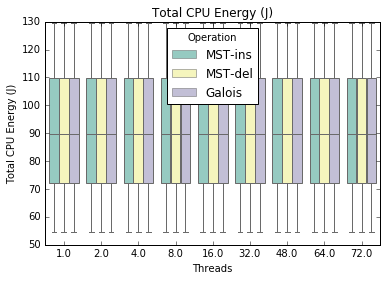

['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '620.244']
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '611.534']
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '608.439']
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '1116.18']
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '128.519']
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '124.992']
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '121.14']
['Galois', 'All', '4036538', '8', 'com-lj-org-weighted', '100', '1000000', '1', '1', 'Total CPU Energy (J)', '129.663']
['Galois', 'All', '4036538', '8', 'com-lj

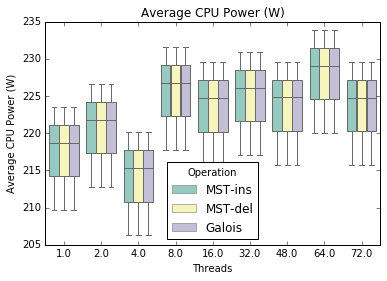

In [62]:
algnames = [x.split('/')[0] for x in algs]

for algfull in algs:
    fname = algfull.lower() + '/parsed-power-aggregate.txt'
    alg = algfull.split('/')[0]
    lines = open(fname).readlines()
    for what in whats:
        extractAndPlotData(lines,alg,algnames,what,epvs,nws,insperc)